In [3]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [4]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'C:/dr_final/train.csv')


diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

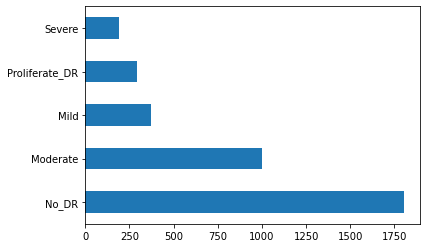

In [5]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

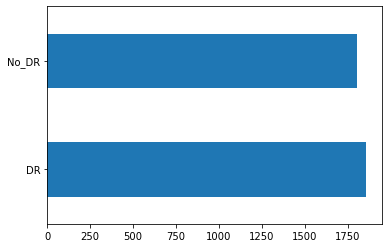

In [6]:
df['binary_type'].value_counts().plot(kind='barh')

In [7]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [8]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [10]:
# Copy images to respective working directory
src_dir = r'C:/dr_final/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [11]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [14]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
# model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
81/81 [==============================] - 45s 544ms/step - loss: 0.3909 - acc: 0.8833 - val_loss: 0.9282 - val_acc: 0.5073
Epoch 2/30
81/81 [==============================] - 48s 591ms/step - loss: 0.2413 - acc: 0.9254 - val_loss: 0.6639 - val_acc: 0.7073
Epoch 3/30
81/81 [==============================] - 53s 650ms/step - loss: 0.1560 - acc: 0.9450 - val_loss: 0.5974 - val_acc: 0.6309
Epoch 4/30
81/81 [==============================] - 41s 505ms/step - loss: 0.1020 - acc: 0.9563 - val_loss: 0.2723 - val_acc: 0.8782
Epoch 5/30
81/81 [==============================] - 41s 504ms/step - loss: 0.0635 - acc: 0.9766 - val_loss: 1.7575 - val_acc: 0.9036
Epoch 6/30
81/81 [==============================] - 42s 514ms/step - loss: 0.0604 - acc: 0.9801 - val_loss: 1.5028 - val_acc: 0.8345
Epoch 7/30
81/81 [==============================] - 40s 499ms/step - loss: 0.0334 - acc: 0.9883 - val_loss: 4.1998 - val_acc: 0.6400
Epoch 8/30
81/81 [==============================] - 46s 563ms/step - 

In [15]:
model.save('64x3-CNN.model')

INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [16]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)


C:\Users\Abhi\AppData\Local\Temp/ipykernel_708/4010420734.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 5s 302ms/step - loss: 1.8431 - acc: 0.8909
Accuracy:  0.8909090757369995


# ****Diabet Retinopathy Detection Section****

In [17]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')
    

    

1/1 [==============================] - 0s 123ms/step
DR


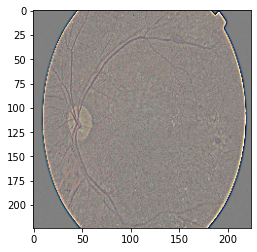

In [19]:
predict_class('C:/dr_final/gaussian_filtered_images/gaussian_filtered_images/Severe/03c85870824c.png')